In [147]:
!pip install --quiet wikipedia==1.4.0 langchain-core==0.3.59 langgraph==0.5.3 langchain-openai==0.3.16 langchain-experimental==0.3.4 pydantic==2.11.9 python-dotenv==1.0.1 requests==2.31.0
!pip install rapidfuzz
!pip install tabulate


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for tabulate from https://files.pythonhosted.org/packages/40/44/4a5f08c96eb108af5cb50b41f76142f0afa346dfa99d5296fe7202a11854/tabulate-0.9.0-py3-none-any.whl.metadata

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [34]:
import requests
import json

base_url = 'https://fantasy.premierleague.com/api/'

bootstrap_url = base_url + 'bootstrap-static'

data = json.loads(requests.get(bootstrap_url).text)


In [ ]:
from typing import Annotated
from langchain_core.tools import tool
import pandas as pd
import os
from dotenv import load_dotenv

@tool
def team_data(team_name: Annotated[str, "The name of the English Premier League Team's stats for the current season to look up."]) -> str:
    """
    Use this to look-up latest football team-level performance data for teams in the English Premier League (EPL).

    leave team_name blank to get data for all teams. Do this by passing an empty string ("") as the team_name. Try doing this if I don't specify a team. 
    If I ask for a ranking of teams, you should first get data for all teams, then rank them accordingly and make sure that the ranking is correct. 
    Double check your work if needed. Don't output false rankings and only output it if you're sure it's correct and accurate.

    The fields strength_overall_home, strength_overall_away, strength_attack_home, strength_attack_away,
    strength_defence_home, and strength_defence_away are all ratings between 1000 and 1400 that indicate how strong a team is in those areas.
    1000 is the worst possible rating and 1400 is the best possible rating.
    """
    team_data = data['teams']
    df = pd.DataFrame(team_data)
    df = df.drop(columns=['code', 'draw', 'form', 'id', 'loss', 'played', 'points', 'strength', 'team_division', 'unavailable', 'win'])
    
    if team_name.strip() == "":
        return df.to_markdown()
    
    team_info = df[df['name'].str.lower() == team_name.lower()]
    if team_info.empty:
        return f"No data found for team: {team_name}"
    return team_info.to_markdown()

@tool
def get_player_name_from_id(player_id: Annotated[int, "The ID of the English Premier League Player whose name you want to look up."]) -> str:
    """
    Use this to look-up the name of a player in the English Premier League (EPL) given their player ID.
    """
    player_data = data['elements']
    df = pd.DataFrame(player_data)
    player_info = df[df['id'] == player_id]
    if player_info.empty:
        return f"No data found for player ID: {player_id}"
    player_name = f"{player_info.iloc[0]['first_name']} {player_info.iloc[0]['second_name']}"
    return player_name


@tool
def fpl_scoring_rules() -> str:
    """
    Use this to look-up the latest scoring rules for the English Premier League (EPL) fantasy football game.
    long_play: player played 60 or more minutes
    short_play: player played less than 60 minutes
    """
    scoring_data = data['game_config']['scoring']
    df = pd.DataFrame(scoring_data)
    return df.to_markdown()

@tool
def player_types() -> str:
    """
    Use this to look-up the different player types/positions in the English Premier League (EPL) fantasy football game.
    """
    element_types_data = data['element_types']
    df = pd.DataFrame(element_types_data)
    return df.to_markdown()

@tool 
def my_fpl_team_players(
            user_id: Annotated[int, "The user's fantasy premier league team ID to look up information for."],
            gw: Annotated[int, "FPL Gameweek number. Must be between 1 and 38. Unless specified otherwise, use the most recent gameweek that is on-going or has just ended."]) -> str:
    """
    Use this to look-up the players in a user's fantasy premier league team for a specific gameweek.
    """
    url = f'https://fantasy.premierleague.com/api/entry/{user_id}/event/{gw}/picks/'
    response = requests.get(url)
    team_data = json.loads(response.text)
    team_data = team_data['picks']
    df = pd.json_normalize(team_data)
    return df.to_markdown()

## General GW Tools
@tool
def fixture_info_for_gw(gw: Annotated[int, "The fpl gameweek number to look up match information for."]) -> str:
    """
    Use this to look-up latest match information for a specific gameweek in the English Premier League (EPL).
    The function outputs a markdown table containing details about each fixture in the specified gameweek.

    For each fixture, the following information is provided:
    code: Unique identifier for the fixture
    event: Gameweek number
    finished: Boolean indicating if the match has finished
    finished_provisional: Boolean indicating if the match is provisionally finished
    id: Unique ID for the fixture
    kickoff_time: Scheduled kickoff time of the match
    minutes: Minutes played in the match
    provisional_start_time: Boolean indicating if the start time is provisional
    team_a: ID of the away team
    team_a_score: Score of the away team
    team_h: ID of the home team
    team_h_score: Score of the home team
    stats: List of statistics for the match if the match has been played
    team_h_difficulty: Difficulty rating for the home team
    team_a_difficulty: Difficulty rating for the away team
    pulse_id: Unique pulse ID for the fixture
    """
    url = f'https://fantasy.premierleague.com/api/fixtures/?event={gw}'
    fixtures_data = json.loads(requests.get(url).text)
    df = pd.DataFrame(fixtures_data)
    if df.empty:
        return f"No match data found for gameweek: {gw}"
    return df.to_markdown()

@tool
def current_gw_status() -> str:
    """
    Use this to look-up the current gameweek number and the live status of the current gameweek. 
    The output contains a list of days in YYYY-MM-DD format for which there are matches scheduled in the current gameweek. 
    
    For each day, the following information is provided:
    bonus_added: Boolean indicating if bonus points have been added for matches on that day
    date: The date of the matches in YYYY-MM-DD format
    event: Gameweek number
    
    There is also a field called 'leagues', which is either 'updating' or 'complete'. 
    If it's 'updating', it means that the current gameweek is still ongoing and match results are still being updated. 
    If it's 'complete', it means that the current gameweek has finished and all match results have been updated.
    """
    endpoint = '/event-status'
    url = base_url + endpoint
    response = requests.get(url)
    if response.status_code != 200:
        return f"Failed to retrieve current gameweek status. HTTP Status Code: {response.status_code}"
    status_data = json.loads(response.text)
    df = pd.DataFrame(status_data)
    return df.to_markdown()

@tool
def fpl_gw_info(gw_number: Annotated[int, "The fpl gameweek number to look up information for."]) -> str:
    """
    Use this to look-up latest information about a specific gameweek in the English Premier League (EPL).
    """
    events_data = data['events']
    df = pd.DataFrame(events_data)
    gw_info = df[df['id'] == gw_number]
    if gw_info.empty:
        return f"No data found for gameweek: {gw_number}"
    return gw_info.to_markdown()


## FPL-specific Tools
@tool
def fpl_league_standings(league_id: Annotated[int, "The ID of the FPL league to look up standings for."]) -> str:
    """
    Use this to look-up the current standings of a specific FPL league. 
    The output contains a markdown table with the following information for each team in the league:
    - entry: Unique identifier for the team
    - entry_name: Name of the team
    - event_total: Total points scored by the team in the current gameweek
    - id: Unique ID for the league standing entry
    - last_rank: The team's rank in the previous gameweek
    - movement: Change in rank from the previous gameweek (positive means moved up, negative means moved down)
    - player_name: Name of the team manager
    - rank: Current rank of the team in the league
    - total: Total points scored by the team in all gameweeks so far
    """
    url = f'https://fantasy.premierleague.com/api/leagues-classic/{league_id}/standings/'
    response = requests.get(url)
    if response.status_code != 200:
        return f"Failed to retrieve league standings. HTTP Status Code: {response.status_code}"
    standings_data = json.loads(response.text)
    standings_list = standings_data['standings']['results']
    df = pd.DataFrame(standings_list)
    if df.empty:
        return f"No standings data found for league ID: {league_id}"
    return df.to_markdown()

@tool
def most_valuable_fpl_teams():
    """Use this to look-up the most valuable FPL teams in the current season.
    The output contains a markdown table with the following information for each team:
- entry: Unique identifier for the team
- entry_name: Name of the team
- id: Unique ID for the team. Use this id to look up more information about the team if needed (like the players in the team).
- player_name: Name of the team manager
- team_value: Current value of the team in hundred thousands (e.g., 1000 means £100.0m)
    """


    url = base_url + 'stats/most_valuable_teams'
    response = requests.get(url)
    if response.status_code != 200:
        return f"Failed to retrieve most valuable teams data. HTTP Status Code: {response.status_code}"
    valuable_teams_data = json.loads(response.text)
    df = pd.DataFrame(valuable_teams_data)
    if df.empty:
        return "No data found for most valuable teams."
    return df.to_markdown()





## General Tools
from langchain_experimental.utilities import PythonREPL
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user. The chart should be displayed using `plt.show()`."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed the Python REPL tool.\n\nPython code executed:\n\`\`\`python\n{code}\n\`\`\`\n\nCode output:\n\`\`\`\n{result}\`\`\`"

In [13]:
data.keys()

dict_keys(['chips', 'events', 'game_settings', 'game_config', 'phases', 'teams', 'total_players', 'element_stats', 'element_types', 'elements'])

In [16]:
data['teams'][0]

{'code': 3,
 'draw': 0,
 'form': None,
 'id': 1,
 'loss': 0,
 'name': 'Arsenal',
 'played': 0,
 'points': 0,
 'position': 1,
 'short_name': 'ARS',
 'strength': 5,
 'team_division': None,
 'unavailable': False,
 'win': 0,
 'strength_overall_home': 1300,
 'strength_overall_away': 1375,
 'strength_attack_home': 1340,
 'strength_attack_away': 1400,
 'strength_defence_home': 1260,
 'strength_defence_away': 1350,
 'pulse_id': 1}

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
load_dotenv()

tools = [team_data, python_repl_tool, fpl_gw_info, fpl_scoring_rules, 
         player_types, my_fpl_team_players, get_player_name_from_id,
         fixture_info_for_gw, current_gw_status]

llm = ChatOpenAI(model="gpt-4o-mini", base_url='https://openrouter.ai/api/v1', openai_api_key=os.getenv('OPENAI'))
# Tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def llm_node(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [20]:
from langgraph.prebuilt import ToolNode, tools_condition

# Create the llm and tools nodes
graph_builder.add_node("llm", llm_node)


tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Add the edges
graph_builder.add_edge(START, "llm")
graph_builder.add_conditional_edges("llm", tools_condition, ['tools', END])
graph_builder.add_edge("tools", "llm") 

graph = graph_builder.compile()

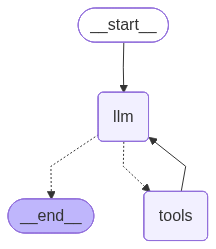

In [21]:
# Visualize your graph
graph

In [22]:
from IPython.display import Markdown, display

def print_stream(stream):
    for chunk in stream:
        for node, data in chunk.items():
            print(f"\n{'='*50}\nNode: {node}\n{'='*50}")
            
            if "messages" in data:
                # Get the last message in the chunk
                message = data["messages"][-1]
                
                # If it's an AI Message with content (the final answer)
                if hasattr(message, "content") and message.content:
                    display(Markdown(message.content))
                
                # If it's a Tool Call (showing the intent)
                if hasattr(message, "tool_calls") and message.tool_calls:
                    for tool in message.tool_calls:
                        print(f"🛠️  Calling Tool: {tool['name']} with args: {tool['args']}")
                
                # If it's a Tool Message (the result of the search)
                if node == "tools":
                    # Display the table properly
                    display(Markdown(message.content))

In [25]:
inputs = {"messages": [("user", "Give me details about the next FPL gameweek fixtures. The current gw is 24.")]}
print_stream(graph.stream(inputs, stream_mode="updates"))


Node: llm
🛠️  Calling Tool: fixture_info_for_gw with args: {'gw': 25}

Node: tools


|    |    code |   event | finished   | finished_provisional   |   id | kickoff_time         |   minutes | provisional_start_time   | started   |   team_a | team_a_score   |   team_h | team_h_score   | stats   |   team_h_difficulty |   team_a_difficulty |   pulse_id |
|---:|--------:|--------:|:-----------|:-----------------------|-----:|:---------------------|----------:|:-------------------------|:----------|---------:|:---------------|---------:|:---------------|:--------|--------------------:|--------------------:|-----------:|
|  0 | 2562140 |      25 | False      | False                  |  246 | 2026-02-06T20:00:00Z |         0 | False                    | False     |       16 |                |       11 |                | []      |                   2 |                   3 |     125036 |
|  1 | 2562142 |      25 | False      | False                  |  248 | 2026-02-07T12:30:00Z |         0 | False                    | False     |       18 |                |       14 |                | []      |                   3 |                   3 |     125038 |
|  2 | 2562136 |      25 | False      | False                  |  241 | 2026-02-07T15:00:00Z |         0 | False                    | False     |       17 |                |        1 |                | []      |                   2 |                   5 |     125031 |
|  3 | 2562135 |      25 | False      | False                  |  242 | 2026-02-07T15:00:00Z |         0 | False                    | False     |        2 |                |        4 |                | []      |                   3 |                   4 |     125032 |
|  4 | 2562138 |      25 | False      | False                  |  244 | 2026-02-07T15:00:00Z |         0 | False                    | False     |       19 |                |        3 |                | []      |                   2 |                   2 |     125034 |
|  5 | 2562139 |      25 | False      | False                  |  245 | 2026-02-07T15:00:00Z |         0 | False                    | False     |        9 |                |       10 |                | []      |                   2 |                   3 |     125035 |
|  6 | 2562144 |      25 | False      | False                  |  250 | 2026-02-07T15:00:00Z |         0 | False                    | False     |        7 |                |       20 |                | []      |                   3 |                   2 |     125040 |
|  7 | 2562143 |      25 | False      | False                  |  249 | 2026-02-07T17:30:00Z |         0 | False                    | False     |        5 |                |       15 |                | []      |                   3 |                   4 |     125039 |
|  8 | 2562137 |      25 | False      | False                  |  243 | 2026-02-08T14:00:00Z |         0 | False                    | False     |        8 |                |        6 |                | []      |                   3 |                   3 |     125033 |
|  9 | 2562141 |      25 | False      | False                  |  247 | 2026-02-08T16:30:00Z |         0 | False                    | False     |       13 |                |       12 |                | []      |                   4 |                   4 |     125037 |

|    |    code |   event | finished   | finished_provisional   |   id | kickoff_time         |   minutes | provisional_start_time   | started   |   team_a | team_a_score   |   team_h | team_h_score   | stats   |   team_h_difficulty |   team_a_difficulty |   pulse_id |
|---:|--------:|--------:|:-----------|:-----------------------|-----:|:---------------------|----------:|:-------------------------|:----------|---------:|:---------------|---------:|:---------------|:--------|--------------------:|--------------------:|-----------:|
|  0 | 2562140 |      25 | False      | False                  |  246 | 2026-02-06T20:00:00Z |         0 | False                    | False     |       16 |                |       11 |                | []      |                   2 |                   3 |     125036 |
|  1 | 2562142 |      25 | False      | False                  |  248 | 2026-02-07T12:30:00Z |         0 | False                    | False     |       18 |                |       14 |                | []      |                   3 |                   3 |     125038 |
|  2 | 2562136 |      25 | False      | False                  |  241 | 2026-02-07T15:00:00Z |         0 | False                    | False     |       17 |                |        1 |                | []      |                   2 |                   5 |     125031 |
|  3 | 2562135 |      25 | False      | False                  |  242 | 2026-02-07T15:00:00Z |         0 | False                    | False     |        2 |                |        4 |                | []      |                   3 |                   4 |     125032 |
|  4 | 2562138 |      25 | False      | False                  |  244 | 2026-02-07T15:00:00Z |         0 | False                    | False     |       19 |                |        3 |                | []      |                   2 |                   2 |     125034 |
|  5 | 2562139 |      25 | False      | False                  |  245 | 2026-02-07T15:00:00Z |         0 | False                    | False     |        9 |                |       10 |                | []      |                   2 |                   3 |     125035 |
|  6 | 2562144 |      25 | False      | False                  |  250 | 2026-02-07T15:00:00Z |         0 | False                    | False     |        7 |                |       20 |                | []      |                   3 |                   2 |     125040 |
|  7 | 2562143 |      25 | False      | False                  |  249 | 2026-02-07T17:30:00Z |         0 | False                    | False     |        5 |                |       15 |                | []      |                   3 |                   4 |     125039 |
|  8 | 2562137 |      25 | False      | False                  |  243 | 2026-02-08T14:00:00Z |         0 | False                    | False     |        8 |                |        6 |                | []      |                   3 |                   3 |     125033 |
|  9 | 2562141 |      25 | False      | False                  |  247 | 2026-02-08T16:30:00Z |         0 | False                    | False     |       13 |                |       12 |                | []      |                   4 |                   4 |     125037 |


Node: llm


Here are the fixtures for the next FPL gameweek (Gameweek 25):

| Fixture Code | Home Team | Away Team | Kickoff Time (UTC)       |
|--------------|-----------|-----------|--------------------------|
| 2562140      | Team 11   | Team 16   | 2026-02-06 20:00         |
| 2562142      | Team 14   | Team 18   | 2026-02-07 12:30         |
| 2562136      | Team 1    | Team 17   | 2026-02-07 15:00         |
| 2562135      | Team 4    | Team 2    | 2026-02-07 15:00         |
| 2562138      | Team 3    | Team 19   | 2026-02-07 15:00         |
| 2562139      | Team 10   | Team 9    | 2026-02-07 15:00         |
| 2562144      | Team 20   | Team 7    | 2026-02-07 15:00         |
| 2562143      | Team 15   | Team 5    | 2026-02-07 17:30         |
| 2562137      | Team 6    | Team 8    | 2026-02-08 14:00         |
| 2562141      | Team 12   | Team 13   | 2026-02-08 16:30         |

(Note: Team numbers correspond to the team's unique identifier in the league.) 

If you need more specific information about the teams, let me know!